In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from datetime import datetime
from torch import nn
from torch.utils.data import dataloader
from methods import *

In [2]:
weeks_until_election = round((datetime.strptime("2026-04-04", "%Y-%m-%d")-datetime.strptime(datetime.today().strftime('%Y-%m-%d'), "%Y-%m-%d")).days/7)
weeks_until_election

15

In [3]:
data = pd.read_csv("../data/voxmeter.csv")
data

,party_letter,votes,date
0,A,19.2,2025-10-05
1,B,4.8,2025-10-05
2,C,6.9,2025-10-05
3,F,13.1,2025-10-05
4,H,1.8,2025-10-05
...,...,...,...
139,O,6.8,2025-12-21
140,V,12.2,2025-12-21
141,Æ,10.0,2025-12-21
142,Ø,6.1,2025-12-21


In [4]:
blue_block = Block(parties="CHIOVÆ")
red_block = Block(parties="ABFØÅ")
goverment = Block(parties="AMV")
blue_block_outside = Block(parties="CHIOÆ")
red_block_outisde = Block(parties="BFØÅ")
blocks = [blue_block, red_block, goverment, blue_block_outside, red_block_outisde]

,party_letter,votes,date
9,Æ,9.1,2025-10-05
21,Æ,9.5,2025-10-12
33,Æ,9.0,2025-10-19
45,Æ,9.3,2025-10-26
57,Æ,8.0,2025-11-02
69,Æ,9.5,2025-11-09
81,Æ,9.2,2025-11-16
93,Æ,8.2,2025-11-23
105,Æ,8.5,2025-11-30
117,Æ,8.6,2025-12-07


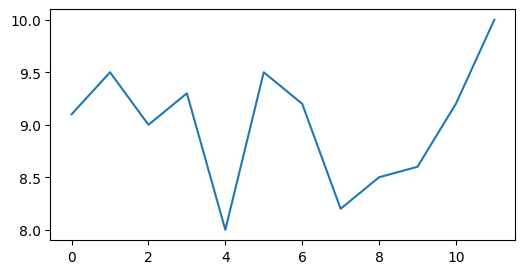

In [5]:
party_data = Party("Æ").party_data
votes = party_data.get("votes").to_list() # type: ignore
display(party_data)
plt.figure(figsize=[6, 3])
plt.plot(range(len(votes)), votes)
plt.show()

In [6]:
party_data

,party_letter,votes,date
9,Æ,9.1,2025-10-05
21,Æ,9.5,2025-10-12
33,Æ,9.0,2025-10-19
45,Æ,9.3,2025-10-26
57,Æ,8.0,2025-11-02
69,Æ,9.5,2025-11-09
81,Æ,9.2,2025-11-16
93,Æ,8.2,2025-11-23
105,Æ,8.5,2025-11-30
117,Æ,8.6,2025-12-07


In [7]:
X_train = torch.tensor(votes[:-1])
y_train = torch.tensor(votes[1:])
X_test = torch.tensor(votes[:-1])
y_test = torch.tensor(votes[-1])
print(f"X_train length: {len(X_train)}")
print(f"y_train length: {len(y_train)}")
print(f"X_test length: {X_test.numel()}")
print(f"y_test length: {y_test.numel()}")

X_train length: 11
y_train length: 11
X_test length: 11
y_test length: 1


In [8]:
sequince_length = 3
X, y = create_sequences(X_train.numpy(), seq_length=sequince_length)

trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [9]:
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Hidden state is reset for each epoch
    outputs, _, _ = model(trainX)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [50/500], Loss: 0.2838
Epoch [100/500], Loss: 0.2738
Epoch [100/500], Loss: 0.2738
Epoch [150/500], Loss: 0.2737
Epoch [200/500], Loss: 0.2736
Epoch [150/500], Loss: 0.2737
Epoch [200/500], Loss: 0.2736
Epoch [250/500], Loss: 0.2736
Epoch [300/500], Loss: 0.2735
Epoch [250/500], Loss: 0.2736
Epoch [300/500], Loss: 0.2735
Epoch [350/500], Loss: 0.2735
Epoch [400/500], Loss: 0.2733
Epoch [350/500], Loss: 0.2735
Epoch [400/500], Loss: 0.2733
Epoch [450/500], Loss: 0.2732
Epoch [450/500], Loss: 0.2732
Epoch [500/500], Loss: 0.2729
Epoch [500/500], Loss: 0.2729


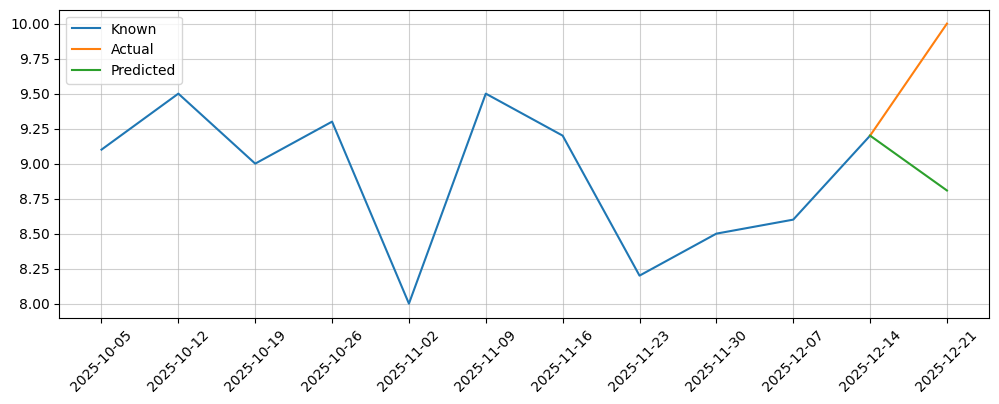

Predicted Vote: 8.81
Actual Vote: 10.00
MAE: 1.192


In [10]:
model.eval()

# Reshape X_test to (Batch Size, Sequence Length, Features)
# Use the last sequince_length elements for prediction
testX = X_test[-sequince_length:].view(1, -1, 1).float()

with torch.no_grad():
    y_pred, _, _ = model(testX)

dates = pd.to_datetime(data["date"].unique())
dates = dates.sort_values()

plt.figure(figsize=[12, 4])
plt.plot(dates[:-1], X_test, label="Known")
plt.plot(dates[-2:], torch.cat([X_test[-1].unsqueeze(0), y_test.unsqueeze(0)]), label="Actual")
plt.plot(dates[-2:], torch.cat([X_test[-1].unsqueeze(0), y_pred.flatten()]), label="Predicted")
plt.xticks(dates, rotation=45)
plt.grid(alpha=0.6)
plt.legend()
plt.show()

print(f"Predicted Vote: {y_pred.item():.2f}")
print(f"Actual Vote: {y_test.item():.2f}")
print(f"MAE: {abs((y_pred.item()-y_test.item())):.3f}")